In [1]:
from dotenv import load_dotenv

load_dotenv()

True

#### Multi Agente

In [2]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command

In [3]:
tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "Código de Python a ejecutar"],
):
    """Herramienta REPL de Python"""

    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Error en la ejecución. Error: {repr(e)}"
    
    result_str = f"Ejecución con éxito:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nSi completaste todas las tareas, responde con FINAL ANSWER."
    )

In [4]:
def make_system_prompt(suffix: str) -> str:
    return (
        "Eres un asistente de inteligencia artificial, que colabora con otros asistentes."
        " Utiliza las herramientas proporcionadas para avanzar hacia la respuesta de la pregunta."
        " Si no puedes responder completamente, está bien, otro asistente con herramientas diferentes"
        " continuará desde donde lo dejaste. Ejecuta lo que puedas para avanzar."
        " Si tú o alguno de los otros asistentes tiene la respuesta final o el entregable,"
        " comienza tu respuesta con FINAL ANSWER para que el equipo sepa que debe detenerse."
        f"\n{suffix}"
    )

In [5]:
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [6]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "Solo puedes hacer investigaciones. Estás trabajando con un asistente chart generator."
    ),
)


def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", "__end__"]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart agent and node
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "Solo puedes generar gráficos. Estás trabajando con un asistente researcher."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", "__end__"]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

In [7]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()


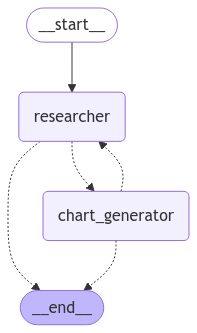

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### Prueba

================================ Human Message =================================

necesito crear un gráfico con la inflación desde el 2010 hasta el 2024 en Chile una vez termines el gráfico, termina.
================================ Human Message =================================
Name: researcher

Basado en mi investigación, he recopilado los siguientes datos de inflación anual para Chile desde 2010 hasta 2024:

2010: 1.4%
2011: 3.3%
2012: 3.0%
2013: 1.9%
2014: 4.4%
2015: 4.3%
2016: 3.8%
2017: 2.2%
2018: 2.3%
2019: 2.3%
2020: 3.0%
2021: 7.2%
2022: 11.6%
2023: 7.6%
2024: 4.5% (datos más recientes)

Ahora el asistente de generación de gráficos puede usar estos datos para crear la visualización solicitada. Los datos están organizados por año (eje X) y porcentaje de inflación (eje Y).

Le paso el control al asistente de generación de gráficos para que pueda crear la visualización con estos datos.


Python REPL can execute arbitrary code. Use with caution.


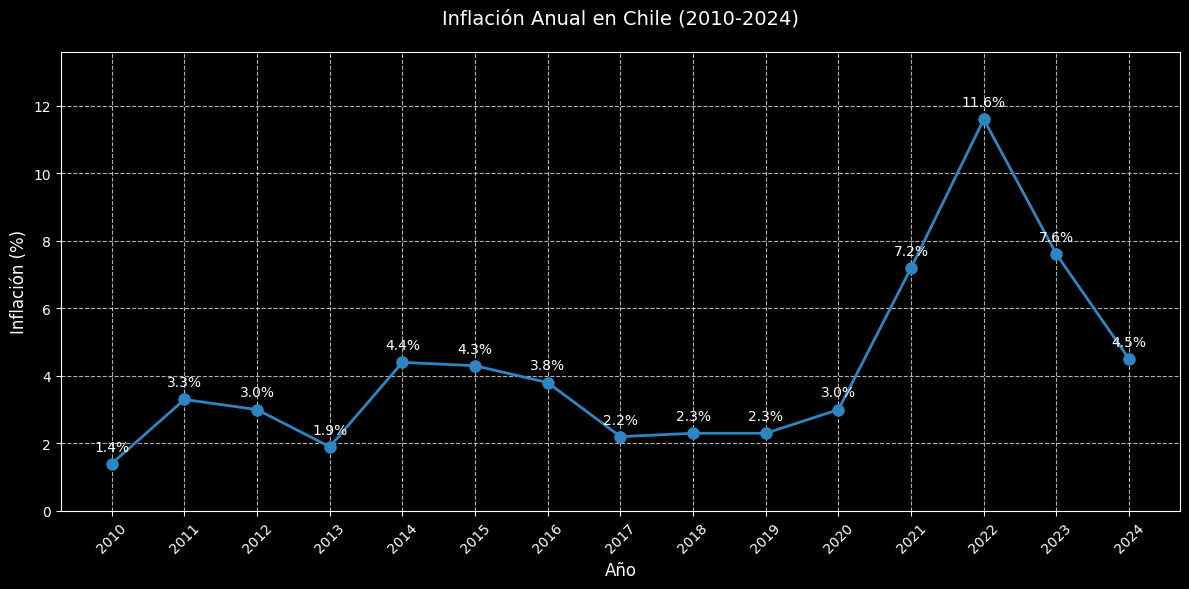

================================ Human Message =================================
Name: chart_generator

FINAL ANSWER: He creado un gráfico de líneas que muestra la evolución de la inflación en Chile desde 2010 hasta 2024. El gráfico incluye:

- Una línea azul con marcadores circulares para cada punto de datos
- Etiquetas con los valores exactos de inflación para cada año
- Una cuadrícula para mejor legibilidad
- Título y etiquetas en los ejes
- Los años rotados 45 grados para mejor visualización
- Los valores de inflación expresados en porcentaje

El gráfico muestra claramente la tendencia de la inflación, destacando el pico significativo en 2022 (11.6%) y la posterior tendencia a la baja hasta 2024 (4.5%).


In [9]:
input = {
    "messages": [
        (
            "user",
            "necesito crear un gráfico con la inflación desde el 2010 hasta el 2024 en Chile una vez termines el gráfico, termina.",
        )
    ],
}

config = {"recursion_limit": 150}

for event in graph.stream(input, stream_mode="values", config=config):
    event["messages"][-1].pretty_print()
